In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import gamma
import scipy
from scipy.special import gammaln, betaln

%matplotlib inline

## Generate Poisson data, compare Poisson vs. negBin model

I will generate observed data from a Poisson distribution with a certain lambda. Then I will train a MDN to approximate the posterior over model indices. As models I use a Poisson with Gamma prior and a negative Binomial with Beta prior. 

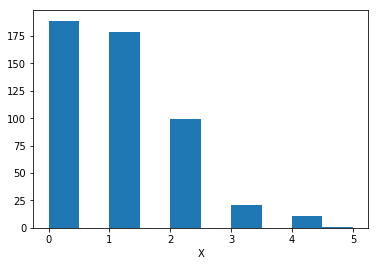

In [2]:
N = 500  # size of toy data
true_lam = 1.

# set prior parameters 
shape = 9.
scale = .5
alp = 2. 
bet = 5.
r = 10

X_o = np.random.poisson(lam=true_lam, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))

plt.hist(X_o, bins='auto');
plt.xlabel('X');

## Define functions for generating data from the two different models

In [3]:
def generate_poisson(N, shape, scale): 
    
    # sample from prior
    theta = np.random.gamma(shape, scale)
    # generate samples
    x = np.random.poisson(lam=theta, size=N)
    
    sx = np.mean(x).astype(float)
    
    return theta, sx
    
def generate_negbin(N, r, alpha, beta):
    # sample from prior
    theta = np.random.beta(alpha, beta)
    
    # generate samples
    x = np.random.negative_binomial(r, theta, size=N)
    
    # calculate summary stats
    sx = np.mean(x).astype(float)
    if sx < 1.: 
        print(x, sx, theta)
    
    return theta, sx

def generate_dataset(n_samples, sample_size, normalize=False): 
    
    X = []
    thetas = []
    m = []

    # for every sample we want a triplet (m_i, theta, sx)
    for i in range(n_samples): 
        
        # sample model index 
        m_i = np.round(np.random.rand()).astype(int)
    
        # generate data from model 
        theta, sx = generate_negbin(sample_size, r, alp, bet) if m_i else generate_poisson(sample_size, 
                                                                                                      shape, 
                                                                                                      scale)
    
        X.append([sx])
        thetas.append([theta])
        m.append([int(m_i)])
                 
    X = np.array(X)
    xmean = X.mean(axis=0)
    xstd = X.std(axis=0)    
    if normalize:
        X = (X - xmean) / xstd

    return m, np.array(thetas), X, (xmean, xstd)

## Define separate networks for fitting the prior parameter posterior and the model posterior

In [4]:
def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

class MDN_psi(nn.Module):
    
    def __init__(self, ndim_input=1, ndim_output=2, n_hidden=5, n_components=1):
        super(MDN_psi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.m_out = nn.Linear(n_hidden, ndim_output)

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_m = self.m_out(act)
        return out_m
    
def train_psi(X, Y, model, optim, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]
    
    losses = []

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))            
            y_var = Variable(torch.LongTensor(y_batch)).view(n_minibatch)
            
            (out_act) = model(x_var)
            loss = lossfun(out_act, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.data[0])

        if (epoch + 1) % 100 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim, losses

## Generate a large data set of triplets (m, theta, sx)

Then separate it into sets for model 1 and model 2 and train the phi networks separately. 

In [5]:
# generate data 
m, theta, X, norms = generate_dataset(1000, N)
# separate it 
mask = np.array(m).squeeze()
theta1, X1, = theta[mask==0], X[mask==0, :]
theta2, X2, = theta[mask==1], X[mask==1, :]

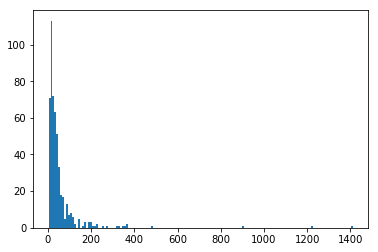

In [6]:
plt.hist(X2, bins='auto');

In [7]:
model = MDN_psi(n_hidden=10)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
lossfun = nn.CrossEntropyLoss()

model_psi, optim_psi, losses = train_psi(X, m, model, optim, n_epochs=1000, n_minibatch=100)

[epoch 0100] loss: 0.5768
[epoch 0200] loss: 0.4502
[epoch 0300] loss: 0.3161
[epoch 0400] loss: 0.2511
[epoch 0500] loss: 0.1439
[epoch 0600] loss: 0.1231
[epoch 0700] loss: 0.0900
[epoch 0800] loss: 0.1554
[epoch 0900] loss: 0.1514
[epoch 1000] loss: 0.1719


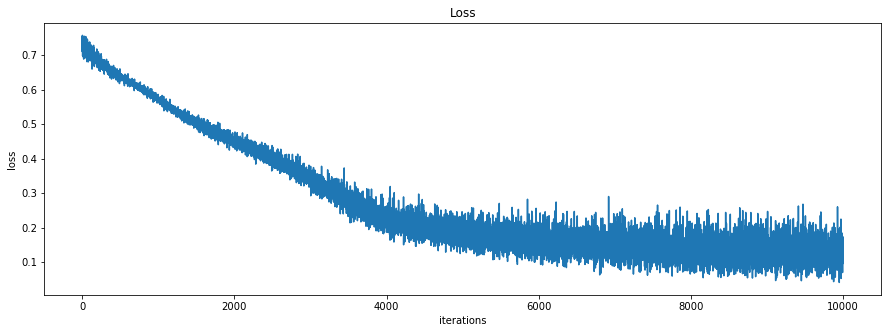

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss');

## Draw many samples and compare predicted to analytical Bayes Factor

In [9]:
def poisson_evidence(x, a, b, N, log=False): 
    x_sum = np.sum(x)
    log_xfac = np.sum(gammaln(x + 1))
    
    result = a * np.log(b) - gammaln(a) - log_xfac + gammaln(a + x_sum) - (a + x_sum)*np.log(b + N)
    
    return result if log else np.exp(result)

def log_nbin_evidence(x, a, b, N, r, log=False): 
    x_sum = np.sum(x)
    
    result = betaln(a + x_sum, b + N * r) - betaln(a, b) + np.sum(np.log(scipy.special.binom(x + r - 1, x)))
    
    return result if log else np.exp(result)

In [15]:
bf_true = []
bf_predicted = []

for i in range(100): 
    
    # draw samples 
    samples = np.random.poisson(true_lam, N)
    
    # apply model for prediction
    stats_o = np.array(np.mean(samples).astype(float)).reshape(1, 1)
    X_var = Variable(torch.Tensor(stats_o))
    (out_act) = model(X_var)
    
    # calculate bf 
    softmax = nn.Softmax()
    posterior_probs = softmax(out_act).data.numpy()
    bf_predicted.append(posterior_probs[0][0] / posterior_probs[0][1])
    
    # because we use a uniform prior the posterior ratio corresponds to the likelihood (evidence) ratio
    e1 = poisson_evidence(samples, shape, scale, N, log=True)
    e2 = log_nbin_evidence(samples, alp, bet, N, r, log=True)
    bf_true.append(e1 - e2)

In [16]:
bf1 = (bf_true - np.mean(bf_true))/np.std(bf_true)
bf2 = (bf_predicted - np.mean(bf_predicted))/np.std(bf_predicted)

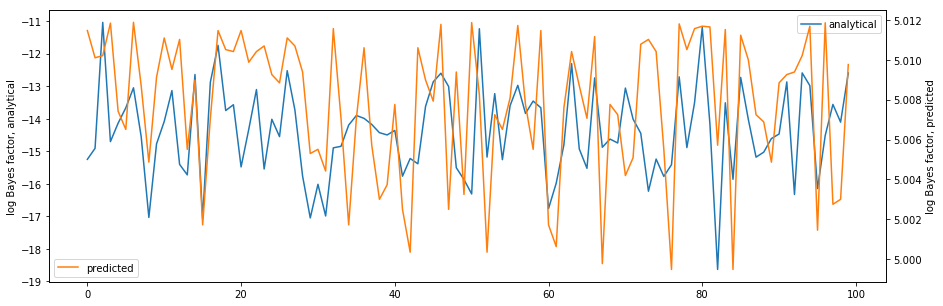

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(bf_true, label='analytical', color='C0')
plt.ylabel('log Bayes factor, analytical')

plt.legend()
plt.twinx()
plt.plot(np.log(bf_predicted), label='predicted', color='C1')
plt.ylabel('log Bayes factor, predicted')
plt.xlabel('different data sets')
plt.legend();

In [18]:
np.corrcoef(bf_true, bf_predicted)

array([[ 1.        ,  0.41191372],
       [ 0.41191372,  1.        ]])